# Main.ipynb
- Before running, make sure to include own custom data and corresponding mask in .nii.gz format, put them in /dataset folder.
- Visualize 3D data 
- Test single image data and evaluate the result

## Import Module

In [ ]:
import os
import torch
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch.nn import DataParallel
from model.resunet3d import ResUNet3D
from model.r2unet3d import R2UNet3D
from model.unet3d import UNet3D
from utils.segmentation_statistics import SegmentationStatistics
from utils.utils import read_data_as_numpy, add_mask_colour, preprocess, to_depth_last, greytoRGB, load_checkpoint, predict, plot_sidebyside
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

## Explore image data

In [ ]:
# Specify the path to the image
IMAGE_PATH = './dataset/test/T2'
FILENAME = 'MRI1_T2.nii.gz'

# Read data as numpy array
image_data = read_data_as_numpy(os.path.join(IMAGE_PATH, FILENAME))

In [ ]:
# Preprocess data, see utils.utils.preprocess for more info
processed_data = preprocess(image_data, to_tensor=False)

# Get the image shape
depth, width, height = processed_data.shape
print(f"Image depth : {depth}")
print(f"Image width : {width}")
print(f"Image height : {height}")

In [ ]:
# Jupyter interaction tool
def explore_3d_image(layer):
    
    plt.figure(figsize=(5,10))
    plt.imshow(processed_data[layer,:,:], cmap='gray')
    plt.title('Explore MRI Data')
    plt.axis('off')
    return layer

interact(explore_3d_image, layer=(0,processed_data.shape[0]-1))

## Explore data labels

In [ ]:
IMAGE_PATH = './dataset/test/T2Masks'
FILENAME = 'MRI1_T2mask.nii.gz'

# Read data as numpy array
label_data = read_data_as_numpy(os.path.join(IMAGE_PATH, FILENAME))

In [ ]:
# Preprocess data, see utils.utils.preprocess for more info
processed_label = preprocess(label_data, to_tensor=False)

# Get the image shape
depth, width, height = processed_label.shape
print(f"Mask depth : {depth}")
print(f"Mask width : {width}")
print(f"Mask height : {height}")

In [ ]:
# Jupyter interaction tool
def explore_3d_image(layer):
    
    plt.figure(figsize=(5,10))
    plt.imshow(processed_label[layer,:,:], cmap='gray')
    plt.title('Explore MRI Masks')
    plt.axis('off')
    return layer

interact(explore_3d_image, layer=(0,processed_data.shape[0]-1))

## Segmented Mask and Image

In [ ]:
feature = greytoRGB(to_depth_last(processed_data))
mask = to_depth_last(processed_label)

# Add colour to mask
mask = add_mask_colour(mask, "blue")
feature[mask.astype(bool)] = 1

def explore_3d_image(layer):
    
    plt.figure(figsize=(5,10))
    plt.imshow(feature[:,:,layer,:])
    plt.title('Explore Segmented MRI')
    plt.axis('off')
    return layer

interact(explore_3d_image, layer=(0,depth-1))

## Model Testing and Evaluation

- Make sure pretrained model are present in the path

In [ ]:
# Path to pretrained model
MODEL_PATH = 'model/model28.pt'

# Network loading configurations
NETWORK = 'ResidualUNet3D'
DEVICE = 'cpu'
THRESHOLD = 0.5

# Specify network
if NETWORK.casefold() == "unet3d":
    model = UNet3D(in_channels=1, out_channels=1, testing=True).to(DEVICE)

else:
    model = ResidualUNet3D(in_channels=1, out_channels=1, testing=True).to(DEVICE)

# If using multiple gpu
if torch.cuda.device_count() > 1:
    model = DataParallel(model)

# Model loading
load_checkpoint(MODEL_PATH, model ,device=DEVICE)

print('Model loaded!')

In [ ]:
print("Predicting image ...")
predicted_mask = predict(model, processed_data, THRESHOLD, DEVICE)

print("Mask predicted")

## Visualizing Predicted Mask

In [ ]:
# Predicted mask shape
depth, width, height = predicted_mask.shape
print(f"Predicted mask depth : {depth}")
print(f"Predicted mask width : {width}")
print(f"Predicted mask height : {height}")

In [ ]:
# Preprocess data
feature = greytoRGB(to_depth_last(processed_data))
mask = to_depth_last(processed_label)
prediction = to_depth_last(predicted_mask)

# Add colour to mask
prediction = add_mask_colour(prediction, "red")
mask = add_mask_colour(mask, "blue")

overlapped = prediction + mask
feature[overlapped.astype(bool)] = 1

# Colour labelling
# Red, blue, purple(red+blue)
colors = [(1,0,0,1), (0,0,1,1), (1,0,1,1)]
values = ['prediction', 'target', 'overlapped']
patches = [ mpatches.Patch(color=colors[i], label=values[i] ) for i in range(len(values)) ]


def explore_3d_image(layer):
    
    plt.figure(figsize=(5,10))
    plt.imshow(feature[:,:,layer,:])
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.title('Output data')
    plt.axis('off')
    return layer

interact(explore_3d_image, layer=(0,depth-1))

In [ ]:
# Plot the feature, mask and grountruth in columns for comparison
plot_sidebyside(processed_data, predicted_mask, processed_label, save_file=False)

## Testing Evaluation

In [ ]:
# Change type to boolean
prediction = predicted_mask.astype(bool)
target = processed_label.astype(bool)

stat = SegmentationStatistics(prediction, target, (3,2,1))
stat.to_df()

In [1]:
import torch
from dataloader import MRIDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [2]:
testdataset = MRIDataset(train=False, transform=T.ToTensor(), elastic=False)
test_loader = DataLoader(dataset=testdataset)

In [6]:
image, label = next(iter(test_loader))
print(torch.std_mean(image))
print(torch.amax(image))

(tensor(1.1143, dtype=torch.float64), tensor(0.3251, dtype=torch.float64))
tensor(7.2760, dtype=torch.float64)


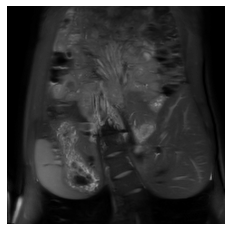

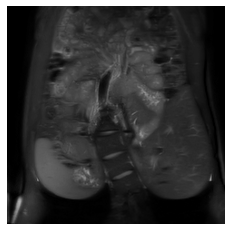

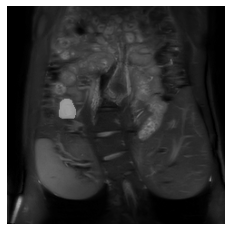

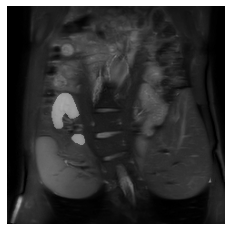

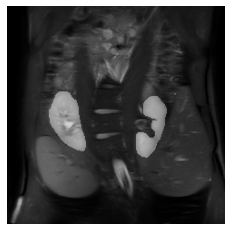

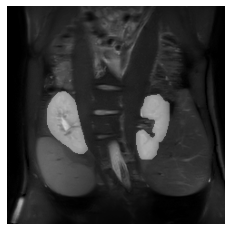

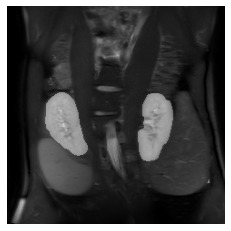

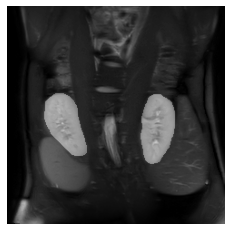

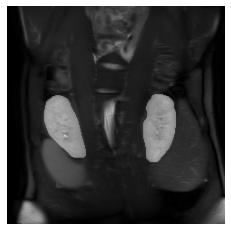

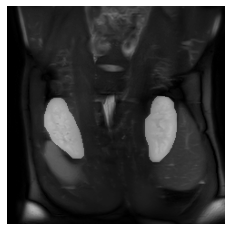

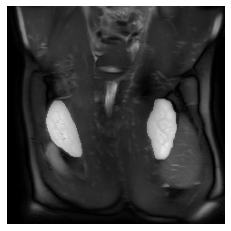

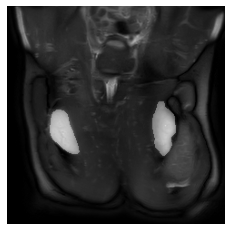

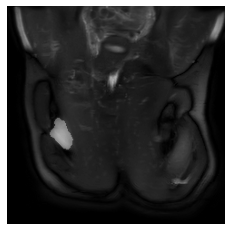

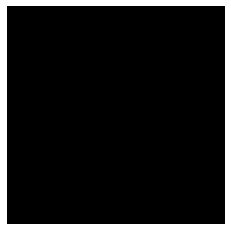

In [7]:
for i in range(14):
    plt.imshow(image[0,0,i,:,:], cmap='gray')
    plt.imshow(label[0,0,i,:,:],cmap='gray', alpha=0.3)
    plt.axis('off')
    plt.show()
    